Condition for this project >>> Cifar-10 dataset under the condition that the you can use 50% of the following classes for training (bird, deer and truck)


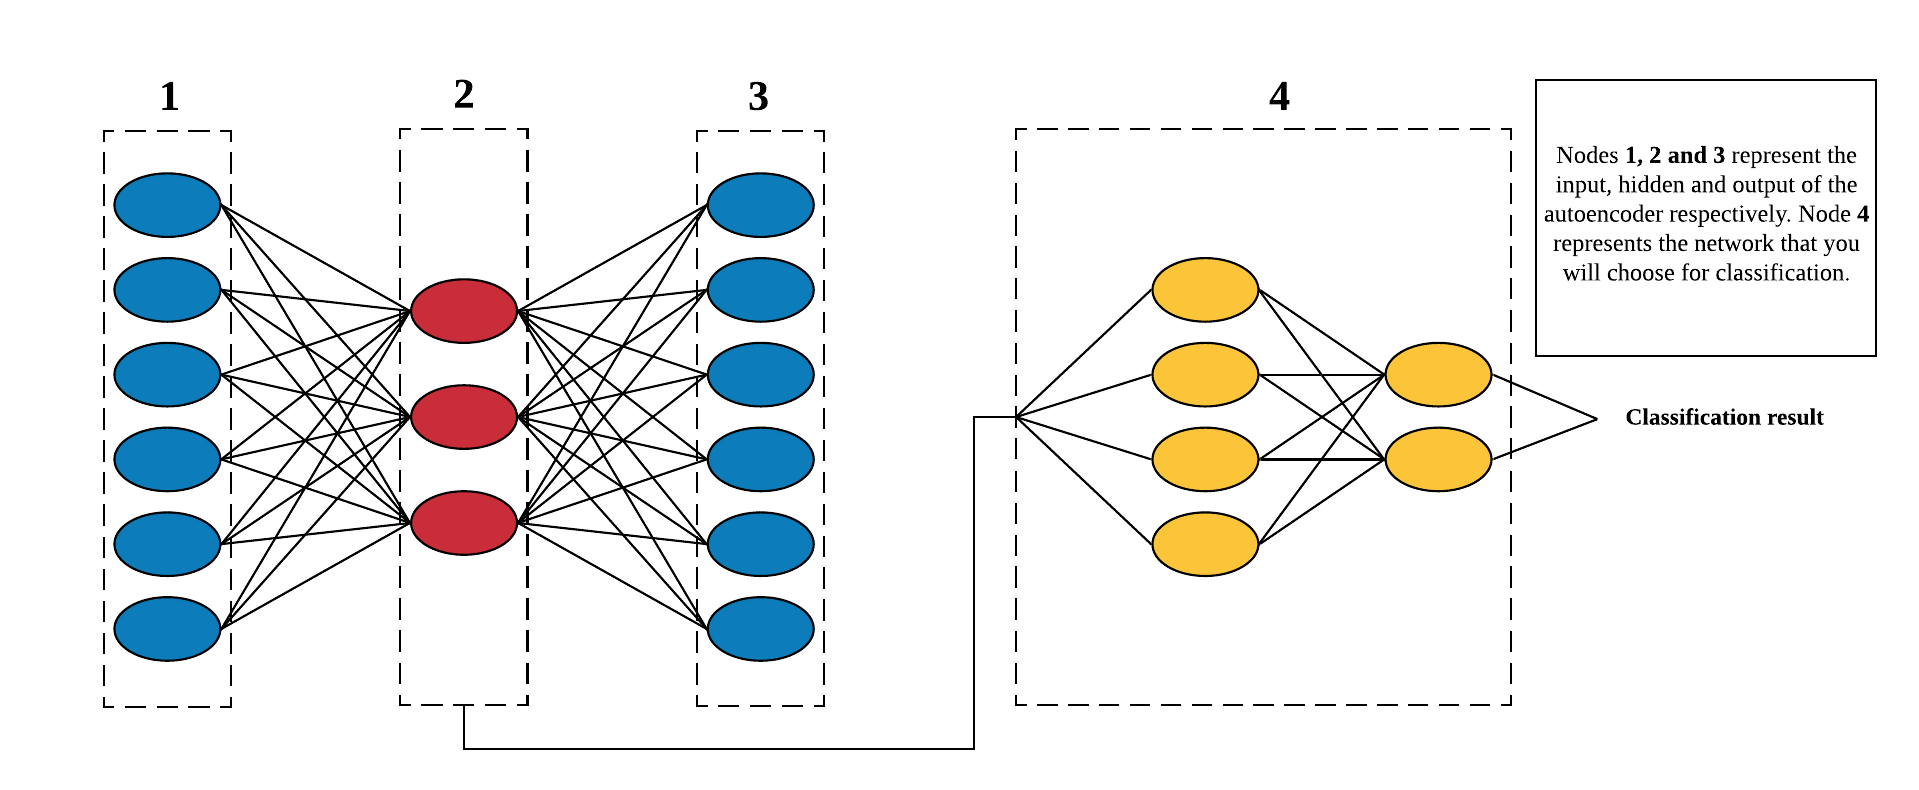

Lets firstly mount the kernel to the google drive of my account.
(I saved models in my account).

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os 
os.chdir('/content/drive//My Drive/Colab Notebooks')
import pickle


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Import all modules and classes that will be used in this homework.

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
import keras.backend as K
import keras
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.objectives import mean_squared_error
from tensorflow.keras import datasets, Input, layers, optimizers
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, ReLU, LeakyReLU, MaxPool2D, Activation, SeparableConv2D, add, Dropout, Flatten, Dense, Conv2DTranspose, InputLayer, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from imblearn.over_sampling import SMOTE, RandomOverSampler
from keras.utils.data_utils import Sequence
from imblearn.keras import balanced_batch_generator

# lets begin this homework.
Firstly, what I want to do is observe the data because I have never seen this data before. Observing the data will make me decide the steps I will use for this problem.

# 1. Data Observation 

I download the image data from tensorflow and check the count of each class.
Note: I will not normalize the data here because I will do it with class tf.keras.ImageDataGenerator.

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
#train_images, test_images = train_images/255, test_images/255     # ((train_images/127.5) - 1)
 
# check the number of each class
counter = Counter(train_labels[:,0])     
for c,v in sorted(counter.items()):
	print('Class=%d, n=%d' % (c, v))


Class=0, n=5000
Class=1, n=5000
Class=2, n=5000
Class=3, n=5000
Class=4, n=5000
Class=5, n=5000
Class=6, n=5000
Class=7, n=5000
Class=8, n=5000
Class=9, n=5000


Now, I want to reduce the data of class 2,4,9 by 50% randomly.(in this case i set the seed in order to get the same result everytime i resuce the data). You also have a choice reduce other class also from the code below. 
Then we check if we reduce the right amount of data. I will explain my choice of data reduction in the later part.

In [ ]:
to_delete_indices = []
half_class = [2,4,9]
for i in range(10):
    all_indices = [j for j, value in enumerate(train_labels[:,0]) if value == i] 
    if i in half_class: 
        del_range = math.ceil(len(all_indices) * 0.5)
    else:
        del_range = math.ceil(len(all_indices) * 0.2) # % you want to delete
    random.Random(4).shuffle(all_indices)
    to_delete_indices.extend(all_indices[0:del_range])
to_delete_indices = sorted(to_delete_indices)
train_images = np.delete(train_images,to_delete_indices,axis=0)
train_labels= np.delete(train_labels,to_delete_indices,axis=0)
# check the number of each class
counter = Counter(train_labels[:,0])     
for c,v in sorted(counter.items()):
	  print('Class=%d, n=%d' % (c, v))
 

Class=0, n=4000
Class=1, n=4000
Class=2, n=2500
Class=3, n=4000
Class=4, n=2500
Class=5, n=4000
Class=6, n=4000
Class=7, n=4000
Class=8, n=4000
Class=9, n=2500


From the code below I can check our data set. It look like we can apply some data augmentation methods to this data but not heavy. For example,zoom in/out ratios, shift, rotation range should not be a big number because the object in the images is mostly fit in the 32 X 32 range of the image. We could apply horzintal flib also.  

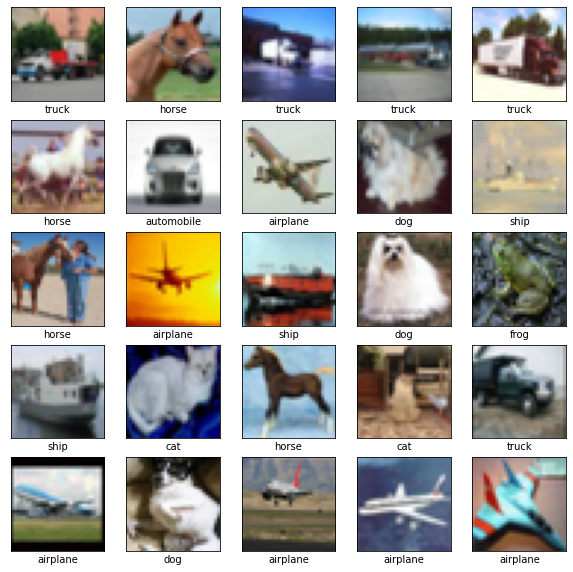

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i+40000], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i+40000][0]])
plt.show()

But why would I want to apply the image augmentation to data ? I will explain it from now.

Here our dataset meets the problem of unbalanced data. This will cause our model to have less chance to learn about the monority classes and so it will have a hard time predict those minority classes. It is more likely to predict those minority classes. To tackle the problem, you have these choices (I will list the choises that I know )[3].

1. You could do under-sampling where you wanna reduce the marjority classes to have the number of examples close to the minority data. However, the down side is that we will lost a lot of information since we will just waste the image data.

2. You could do over-sampling where you can normally re-sampling the data , or just synthesize the new data. The popular systhesising the data is called Smote (I have used with tabular data and it works well so i want o try with images data).  BTW, re-sampling (oversapling with replacement) means you just ramdomly pick the minority class again and so this will not give much information to the model but it can partly solved unbalanced data. 

3. Cost sensitive approach (I have heard this method but I am not so familiar with it so i will not use it this time)
Note: I was thinking to use image augmentation to solve the unbalanced problem. But in fact image augmentation is actually trying to solve overfiting problem[2].
4. weight class. This one act similarly to the re-sampling

Therefore, I decide to tackle the unbalanced data first. I firstly think to use the power of 2 methods under-sampling and Smote together. This is because using Smote alone may cause some problems. It may generate data with mix of minority class. also, it may genereate data that is similar to other class if there is a lot of overlab in the feature space. 


Reference
1.https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6
2.https://eprint.iacr.org/2020/655.pdf
3.https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0


So I tried to apply Smote method and observe the systhesized data. I originally have 2500 examples of each minority classes. i want to generate it not too much so I chose 3500 (2500+1000) and i also under-sampling the marjority class to 4000 examples for each class.

In [ ]:
#Aplly SMOTE to clas 2,4,9 for 
smote_dic = {2:3500, 4:3500 , 9: 3500}
smote = SMOTE(smote_dic)
for_smote = train_images.reshape(len(train_images),-1)
smote_train_images, smote_train_labels = smote.fit_sample(for_smote, train_labels)
smote_train_images = smote_train_images.reshape(len(smote_train_images),32,32,3)
smote_train_labels = smote_train_labels.reshape(len(smote_train_labels),1)
counter = Counter(smote_train_labels[:,0])     
for c,v in sorted(counter.items()):
	  print('Class=%d, n=%d' % (c, v))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

Class=0, n=4000
Class=1, n=4000
Class=2, n=3500
Class=3, n=4000
Class=4, n=3500
Class=5, n=4000
Class=6, n=4000
Class=7, n=4000
Class=8, n=4000
Class=9, n=3500


However, after i visualize the generated data by SMOTE, they dont good as the training data at all. Also, some people also calim that Smote method are not always work and actually aimed for tabular data. 

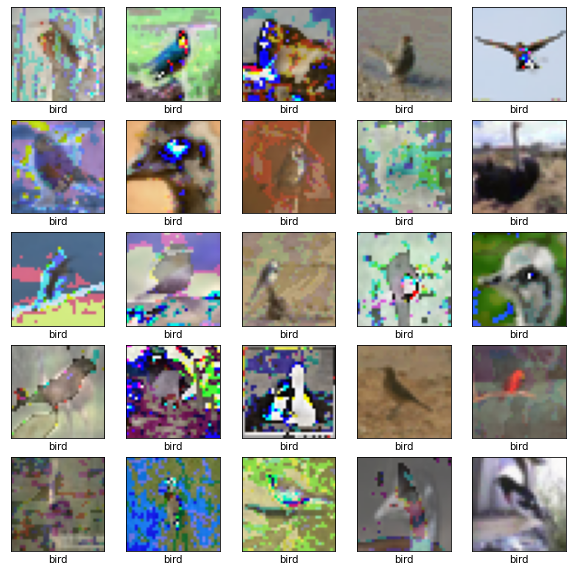

In [ ]:

bird_labels = smote_train_labels[smote_train_labels[:,0] == 2]
bird_images = smote_train_images[smote_train_labels[:,0] == 2,:,:,:]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(bird_images[i+3000], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[bird_labels[i+3000][0]])
plt.show()

#We can seee that the Smote method does not produce a good data at all.

Therefore i have to re-think again. And, I think that I should come back to basic where i just use re-sampling method. Eventhough, this method will not give new information of that class to the model but we still have data augmentation.

Therefore , why dont we use re-sampling + data augmentation? Firsly, the re-sampling will soveled the problem of the unbalanced data, Then, the image augmentation will help adding some new information to the image.

so even thought an image minority classes is picked twice in an eporch, it will not be the same image due to the augmentation. 

Therefore, I will observe data augmentation first.

About the data augmentation, if we want to genelize our model. what technique? I think not only me but other people also have a hard to select the type of data augmentation. For me, I have read a paper about Random erasing which can help to problem when some part of the data is unclear. Also, I work as analogous to dropout so it regularlizes the model. 
'random erasing is a promising technique to guarantee a network pays attention to the entire image, rather than just a subset of it'

Also they calim that this method can work well with cifar-10.
SO i decide to use this augmentation method + light stadard augmentation method.


Reference:
https://arxiv.org/abs/1708.04896

I got code for get_random_eraser fuction from here >> https://github.com/yu4u/cutout-random-erasing.
Then I create visualizeGen fuction is to visialize the result. Here I assign the random fuction to the ImageDataGenerator class.

In [ ]:
# define helper fuction (cutout/ random tennique) + visualize the augmented images
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w] = c
        return input_img
    return eraser

def visualizeGen(images, rotation=0., w_shift=0., h_shift=0., shear=0., zoom=0., h_flip=False, v_flip=False,  preprocess_fcn=None, batch_size=25):
    datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=rotation,
            width_shift_range=w_shift,
            height_shift_range=h_shift,
            brightness_range=[0.7,1.3],
            shear_range=shear,
            zoom_range=zoom,
            fill_mode='nearest',
            horizontal_flip=h_flip,
            vertical_flip=v_flip,
            preprocessing_function=preprocess_fcn)
    i=0
    plt.figure(figsize=(10,10))
    for img_batch in datagen.flow(images, batch_size=batch_size, shuffle=False):
        for j,img in enumerate(img_batch):
            plt.subplot(5,5,j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(img, cmap=plt.cm.binary)
            i=i+1    
        if i >= batch_size:
            break
        plt.show()


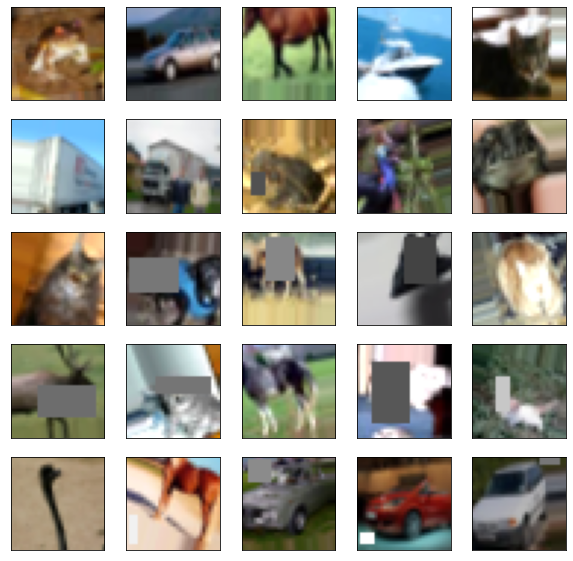

In [ ]:
# see and visualize the augmented images (you can comare it with previous cell where we visualize bird images)
visualizeGen(train_images, rotation=20, w_shift=0.2, h_shift=0.2, shear=0.2, zoom=0.1, h_flip=True, preprocess_fcn=get_random_eraser(v_l=0, v_h=255))  

So I decideed to keep all the majority class and apply resampling + data augmentation.

After I decide the image generate and data preparation method,
# 2. Lets begin the homework

Load data and visualize again from begining and reduce the class 2,4,9.

In [ ]:
# arrage data as the home work require
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
(train_val_images, train_val_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# train_images, test_images = train_images/255, test_images/255     # (train_images/127.5 - 1)
# reduce 50 % of class 2 ,4 ,9 
to_delete_indices = []
half_class = [2,4,9]
for i in [2,4,9]:
    all_indices = [j for j, value in enumerate(train_val_labels[:,0]) if value == i] 
    del_range = math.ceil(len(all_indices) * 0.5)
    random.Random(4).shuffle(all_indices)
    to_delete_indices.extend(all_indices[0:del_range])
to_delete_indices = sorted(to_delete_indices)
train_val_images = np.delete(train_val_images,to_delete_indices,axis=0)
train_val_labels= np.delete(train_val_labels,to_delete_indices,axis=0)
# check the number of each class
counter = Counter(train_val_labels[:,0])     
for c,v in sorted(counter.items()):
	  print('Class=%d, n=%d' % (c, v))
   

Class=0, n=5000
Class=1, n=5000
Class=2, n=2500
Class=3, n=5000
Class=4, n=2500
Class=5, n=5000
Class=6, n=5000
Class=7, n=5000
Class=8, n=5000
Class=9, n=2500


Next ramdomly split 20% of each class to validation set. set seed to get the same suffle.

In [ ]:
# randomly split each class for validation (20 percent)
to_split_indices = []
for i in range(10):
    all_indices = [j for j, value in enumerate(train_val_labels[:,0]) if value == i] 
    split_range = math.ceil(len(all_indices) * 0.2)
    random.Random(5).shuffle(all_indices)
    to_split_indices.extend(all_indices[0:split_range])
to_split_indices = sorted(to_split_indices)
train_images = np.delete(train_val_images,to_split_indices,axis=0)
train_labels = np.delete(train_val_labels,to_split_indices,axis=0)
val_images = train_val_images[to_split_indices]
val_labels = train_val_labels[to_split_indices]


In [ ]:
# next i have to reduce the side to validation set of the marjority class 50 to get the same amount of the minority class

to_delete_indices = []
half_class = [2,4,9]
for i in range(10):
    if i not in half_class:
        all_indices = [j for j, value in enumerate(val_labels[:,0]) if value == i] 
        del_range = math.ceil(len(all_indices) * 0.5)
        random.Random(4).shuffle(all_indices)
        to_delete_indices.extend(all_indices[0:del_range])
to_delete_indices = sorted(to_delete_indices)
val_images = np.delete(val_images,to_delete_indices,axis=0)
val_labels = np.delete(val_labels,to_delete_indices,axis=0)

In [ ]:
# Check
print('traing data')
counter = Counter(train_labels[:,0])     
for c,v in sorted(counter.items()):
	  print('Class=%d, n=%d' % (c, v))
print('validation data')   
counter = Counter(val_labels[:,0])     
for c,v in sorted(counter.items()):
	  print('Class=%d, n=%d' % (c, v))

traing data
Class=0, n=4000
Class=1, n=4000
Class=2, n=2000
Class=3, n=4000
Class=4, n=2000
Class=5, n=4000
Class=6, n=4000
Class=7, n=4000
Class=8, n=4000
Class=9, n=2000
validation data
Class=0, n=500
Class=1, n=500
Class=2, n=500
Class=3, n=500
Class=4, n=500
Class=5, n=500
Class=6, n=500
Class=7, n=500
Class=8, n=500
Class=9, n=500


Firsly, I am creating the balanced data generator for autoencoder. The BalancedDataGenerator class is originally from here >> https://gist.github.com/arnaldog12/16efc663c869b35e2479bd607d56c1da 

However, I have to modify the fuction a bit since the original code return the augmented images(x_batch) and the lebel(y_batch). But, in order to train auto encoder, we need to modify to make the fuction return the y_bacth as x_batch which will be use to compute the MSE loss to measure the reconstruction ability of the Autoencoder.

Here the Y_batch will be exactly the same as x_bacth(which will be in put to the model) because we want the AE encoder to learn to be able to genereate the images as close as the input images.
Also, since we want to apply these augmented power to clasification model later, we set the y_batch to exactly the same as x_batch.

In [ ]:
# Now create a generator class which generate balanced data during traing 
class BalancedDataGenerator_ae(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
    def __len__(self):
        return self.steps_per_epoch
    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        x_batch, y_batch = self.datagen.flow(x_batch, x_batch, batch_size=self.batch_size).next()   
        return x_batch, x_batch 
# also create helper fucition for cut/off random

# this fuction is duplicate from above cell
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w] = c
        return input_img
    return eraser

###
Here we will create the balanced image generator for both training and validation set. The ae_train_generator will aplly image augmentation while ae_val_genereator does not apply anything.
###
we also use the choice to normalize the data here 1/255
we can also choose  ((1/127.5) - 1)  to make the data range from (-1,1)
Note: if you use (-1,1) then ,maybe its better to change the activation fuction at the buttol nexk of autoencode to Tanh fuction. 

In [ ]:
batch_size = 128
ae_train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.7,1.3],
        shear_range=0.2,
        zoom_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True,
        preprocessing_function=get_random_eraser(v_l=0, v_h=255))  
ae_val_datagen = ImageDataGenerator(rescale=1./255)

ae_train_generator = BalancedDataGenerator_ae(train_images, train_labels[:,0], ae_train_datagen, batch_size=batch_size)
train_steps_per_epoch = ae_train_generator.steps_per_epoch
ae_val_generator = BalancedDataGenerator_ae(val_images, val_labels[:,0], ae_val_datagen, batch_size=256)
val_steps_per_epoch = ae_val_generator.steps_per_epoch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


We can test first if our class work well or not

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


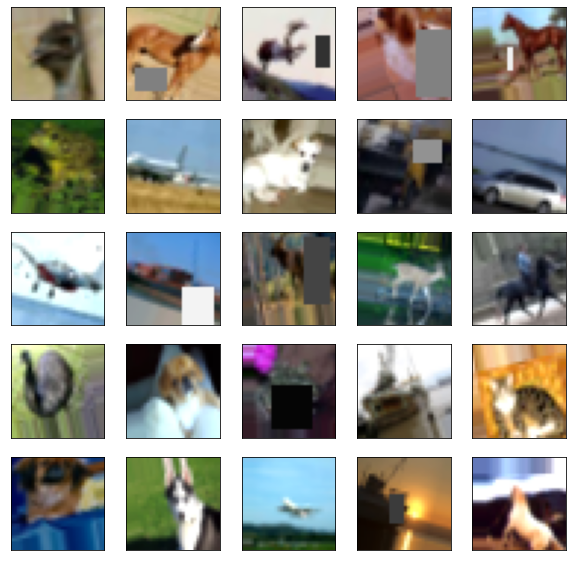

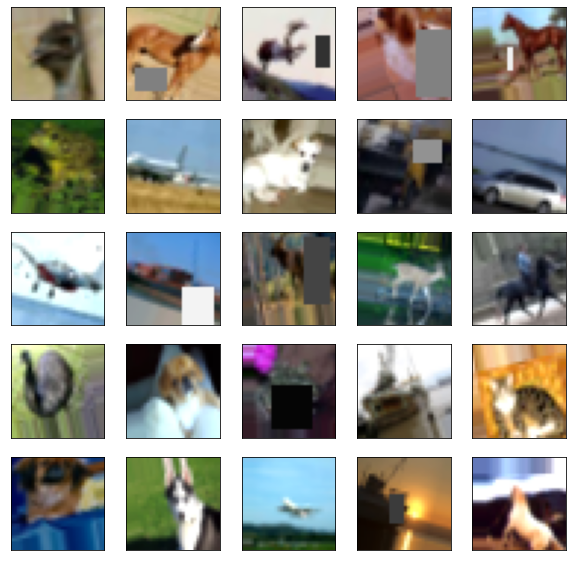

In [ ]:
# visualizing if data generator work okay
imgs = []
ori_imgs = []
for i in range(train_steps_per_epoch):
    img_batch, ori_img_batch = ae_train_generator.__getitem__(0)
    imgs.extend(img_batch)
    ori_imgs.extend(ori_img_batch)      # labels.extend(label_batch[:,0]) for cls

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imgs[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(ori_imgs[i], cmap=plt.cm.binary)
plt.show()

We finish about data part lets continue to model part.

#Autoencoder

Define classes for types of encoder and decoder blocks here.
I define many types of block so that I can experiment it later.
###
Each block of auto encoder a similar architechture as VGG16. This is because I want to make it simple and VGG has outperform many problem.
###
we also have a choice of Resnet and Incention type of block but those network achitecture are design for very deep network. In this problem I will not use that much deep net work because we should start simple first (If I have time I would like to experiment later also).
###
For Encoder bloack, there are 2 types here for rntry and last block.
the diferrence is the activation fiction in the last layer of each type of block. 
###
For Decoder block, I have 2 type of block. one is just a shorter than ther order. (this is because I want o experiment some thing about what heppen betwenn we have more parameters in the encoder than the decoder)
###
I also define stack encoder and decoder. 

In [ ]:
# can also use something like Conv2D(filters=filters, (3,3), activation='relu', padding='same', strides=2)]) instead of max pooling
# can also use something like Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same') instead of upsampling + cov
class BasicCovEncoderEntryBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, padding='same', kernel_regularizer=None):
        if kernel_regularizer is not None:
            kernel_regularizer = L1L2(l1=kernel_regularizer)
        super(BasicCovEncoderEntryBlock, self).__init__()
        self.block = Sequential([
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),  #LeakyReLU
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),   
            MaxPool2D()
        ])

    def call(self, inputs, training=False):
        return self.block(inputs, training=training)

class BasicCovEncoderLastBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, padding='same', kernel_regularizer=None):
        if kernel_regularizer is not None:
            kernel_regularizer = L1L2(l1=kernel_regularizer)
        super(BasicCovEncoderLastBlock, self).__init__()
        self.block = Sequential([
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),   #ReLU() #LeakyReLU
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),
        ])

    def call(self, inputs, training=False):
        return self.block(inputs, training=training)

class BasicCovDecoderBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, padding='same', kernel_regularizer=None):
        if kernel_regularizer is not None:
            kernel_regularizer = L1L2(l1=kernel_regularizer)
        super(BasicCovDecoderBlock, self).__init__()
        self.block = Sequential([        
            Conv2DTranspose(filters=filters, kernel_size=2, strides=2, activation='relu', padding='same'),            
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),
        ])

    def call(self, inputs, training=False):
        return self.block(inputs, training=training)

class BasicCovDecoderBlock2(layers.Layer):
    def __init__(self, filters, kernel_size=3, padding='same', kernel_regularizer=None):
        if kernel_regularizer is not None:
            kernel_regularizer = L1L2(l1=kernel_regularizer)
        super(BasicCovDecoderBlock, self).__init__()
        self.block = Sequential([
            Conv2DTranspose(filters=filters, kernel_size=2, strides=2, activation='relu', padding='same'),
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),
        ])

    def call(self, inputs, training=False):
        return self.block(inputs, training=training)

class BasicUpDecoderBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, padding='same', kernel_regularizer=None):
        if kernel_regularizer is not None:
            kernel_regularizer = L1L2(l1=kernel_regularizer)
        super(BasicUpDecoderBlock, self).__init__()
        self.block = Sequential([
            UpSampling2D(),
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),
        ])

    def call(self, inputs, training=False):
        return self.block(inputs, training=training)

class StackEncoderBlock(layers.Layer):
    def __init__(self):   
        super(StackEncoderBlock, self).__init__()
        self.block = Sequential([
            Flatten(),
            Dense(3072, activation='relu'),
            Dense(2048, activation='relu'),
            Dense(1024, activation='relu'),
            Dense(512, activation='sigmoid'),
        ])        
    def call(self, inputs, training=False):
        return self.block(inputs, training=training)

class StackDecoderBlock(layers.Layer):
    def __init__(self):    
        super(StackDecoderBlock, self).__init__()
        self.block = Sequential([
            Dense(1024, activation='relu'),
            Dense(2048, activation='relu'),
            Dense(3072, activation='sigmoid'),
        ])  
    def call(self, inputs, training=False):
        features = self.block(inputs, training=training)
        features = tf.reshape(features, (-1,32,32,3) )
        return features

Define full Autoencoder moodel with convolution.

There are 2 types that I want to test. Each type consists of encoder which has entryencoder+lastencoder, then, plus the decodeer.

The diferrence between CovAutoencoder1 and CovAutoencoder2 is that the layers of CovAutoencoder2 is shoter so the learning parameter in the necoder side is more. So, when learnin, the CovAutoencoder2 will rely more on encoder than decoder, which it is better for us becaue we want to get the feasture from the encoder to the clasification model. (This is just my assumption).

I additionally define the full stack autoencoder also.

In [ ]:
class CovAutoencoder1(Model): 
    def __init__(self,kernel_regularizer=None):
        super(CovAutoencoder1, self).__init__()

        # Encoder 
        self.cov_ec = self.make_encoder(kernel_regularizer=kernel_regularizer, name='cov_ec')
        # Decoder 
        self.cov_dc = self.make_decoder(kernel_regularizer=kernel_regularizer, name='cov_dc')

    def call(self, inputs, training=None):
        z = self.cov_ec(inputs, training=training)
        x_hat = self.cov_dc(z, training=training)
        return x_hat

    def make_encoder(self, kernel_regularizer=None, name=None):
        model = Sequential(
            [
                BasicCovEncoderEntryBlock(32, kernel_regularizer=kernel_regularizer),
                BasicCovEncoderEntryBlock(64, kernel_regularizer=kernel_regularizer),
                BasicCovEncoderLastBlock(128, kernel_regularizer=kernel_regularizer),
            ],
            name=name
        )
        return model

    def make_decoder(self, kernel_regularizer=None, name=None):
        model = tf.keras.Sequential(
            [
                BasicCovDecoderBlock(64, kernel_regularizer=kernel_regularizer),
                BasicCovDecoderBlock(32, kernel_regularizer=kernel_regularizer),
            ],
            name=name
        )

        if kernel_regularizer is not None:
            kernel_regularizer = L1L2(l1=kernel_regularizer)
        model.add(Conv2D(filters=3, kernel_size=1, padding='same', activation='sigmoid', kernel_regularizer=kernel_regularizer)) # use tanh if data range [-1,1]
        
        return model

class CovAutoencoder2(Model): 
    def __init__(self,kernel_regularizer=None):
        super(CovAutoencoder2, self).__init__()

        # Encoder 
        self.cov_ec = self.make_encoder(kernel_regularizer=kernel_regularizer, name='cov_ec')
        # Decoder 
        self.cov_dc = self.make_decoder(kernel_regularizer=kernel_regularizer, name='cov_dc')

    def call(self, inputs, training=None):
        z = self.cov_ec(inputs, training=training)
        x_hat = self.cov_dc (z, training=training)
        return x_hat

    def make_encoder(self, kernel_regularizer=None, name=None):
        model = Sequential(
            [
                BasicCovEncoderEntryBlock(32, kernel_regularizer=kernel_regularizer),
                BasicCovEncoderEntryBlock(64, kernel_regularizer=kernel_regularizer),
                BasicCovEncoderLastBlock(128, kernel_regularizer=kernel_regularizer),
            ],
            name=name
        )
        return model

    def make_decoder(self, kernel_regularizer=None, name=None):
        model = tf.keras.Sequential(
            [
                BasicCovDecoderBlock2(64, kernel_regularizer=kernel_regularizer),
                BasicCovDecoderBlock2(32, kernel_regularizer=kernel_regularizer),
            ],
            name=name
        )

        if kernel_regularizer is not None:
            kernel_regularizer = L1L2(l1=kernel_regularizer)
        model.add(Conv2D(filters=3, kernel_size=1, padding='same', activation='sigmoid', kernel_regularizer=kernel_regularizer)) # use tanh if data range [-1,1]  

        return model


class StackAutoencoder(Model): 
    def __init__(self):
        super(StackAutoencoder, self).__init__()

        # Encoder 
        self.cov_ec = self.make_encoder(name='st_ec')
        # Decoder 
        self.cov_dc = self.make_decoder(name='st_dc')

    def call(self, inputs, training=None):
        z = self.cov_ec(inputs, training=training)
        x_hat = self.cov_dc (z, training=training)
        return x_hat

    def make_encoder(self,name=None):
        model = Sequential(
            [
                StackEncoderBlock()
            ],
            name=name
        )
        return model

    def make_decoder(self, name=None):
        model = tf.keras.Sequential(
            [
              StackDecoderBlock()
            ],
            name=name
        )
        return model
        
def loss_function(y_true, y_pred): 
   squared_difference = tf.square(y_true - y_pred)
   return tf.reduce_mean(squared_difference, axis=(1,2,3))

Define the trangenerator again. this duplicate with above cell

In [ ]:
batch_size = 128  # I used Batch size 128 to the autoencoder because we try to minimize the regularization effect here
ae_train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.7,1.3],
        shear_range=0.2,
        zoom_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True,
        preprocessing_function=get_random_eraser(v_l=0, v_h=255))  
ae_val_datagen = ImageDataGenerator(rescale=1./255)

ae_train_generator = BalancedDataGenerator_ae(train_images, train_labels[:,0], ae_train_datagen, batch_size=batch_size)
train_steps_per_epoch = ae_train_generator.steps_per_epoch
ae_val_generator = BalancedDataGenerator_ae(val_images, val_labels[:,0], ae_val_datagen, batch_size=256)
val_steps_per_epoch = ae_val_generator.steps_per_epoch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The code to train stack autoencoder with step reduce learning rate.

I found that Stack autoencoder cannot reduce the loss a lot (as expected) compared to Cov type. This maybe because the stack encoder cannot learn to detect the edges from the images or my model is too small for this problem. so I stoped the training (I have tried to train many times,). (Adam, SDG, batchsize, learning rate)

Also, the parameters for this type of encoder is too much compared to Cov autoencoder, which is the main reason why I chooses  Cov type.

In [ ]:
# #train Stack
# kernel_regularizer = None #0.0000001
# ae_model = StackAutoencoder()
# def step_decay(epoch):
#    initial_lrate = 1e-3
#    drop = 0.5
#    epochs_drop = 3
#    lrate = initial_lrate * math.pow(drop,  
#            math.floor((1+epoch)/epochs_drop))
#    return lrate
# lrate = LearningRateScheduler(step_decay)
# epochs = 50
# # optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
# optimizer = Adam(learning_rate=lr_schedule)
# ae_model.compile(optimizer=optimizer, loss = loss_function)
# ae_model.build(input_shape= (None, 32, 32, 3))
# print(ae_model.summary())

# history = ae_model.fit_generator(ae_train_generator, 
#                     steps_per_epoch=train_steps_per_epoch, 
#                     epochs=epochs, 
#                     validation_data=ae_val_generator, 
#                     validation_steps=val_steps_per_epoch)

In [ ]:
# train ae model type 1
kernel_regularizer = None #0.0001
ae_model = CovAutoencoder1(kernel_regularizer)

def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.5
   epochs_drop = 10
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)
epochs = 30
# optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
optimizer = Adam()
ae_model.compile(optimizer=optimizer, loss = loss_function)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='min')
ae_model.build(input_shape= (None, 32, 32, 3))
print(ae_model.summary())

history = ae_model.fit_generator(ae_train_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=ae_val_generator, 
                    validation_steps=val_steps_per_epoch,
                    callbacks = [lrate])

Model: "cov_autoencoder1_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cov_ec (Sequential)          (None, 8, 8, 128)         288352    
_________________________________________________________________
cov_dc (Sequential)          (None, 32, 32, 3)         134083    
Total params: 422,435
Trainable params: 421,155
Non-trainable params: 1,280
_________________________________________________________________
None
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


312/312 [==============================] - 32s 103ms/step - loss: 0.0087 - val_loss: 0.0190
Epoch 2/30
312/312 [==============================] - 32s 103ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 3/30
312/312 [==============================] - 32s 101ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 4/30
312/312 [==============================] - 32s 103ms/step - loss: 0.0025 - val_loss: 0.0053
Epoch 5/30
312/312 [==============================] - 32s 102ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 6/30
312/312 [==============================] - 31s 101ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 7/30
312/312 [==============================] - 31s 100ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 8/30
312/312 [==============================] - 32s 101ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 9/30
312/312 [==============================] - 31s 101ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 10/30
312/312 [==============================] - 31s 100ms/step - loss: 0.0014

In [ ]:
ae_model.save('/content/drive//My Drive/Colab Notebooks/saved_models/ae_model1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive//My Drive/Colab Notebooks/saved_models/ae_model1/assets


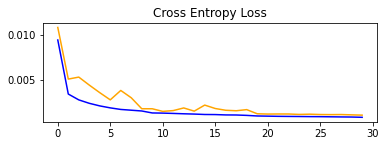

In [ ]:
def summarize_diagnostics(history):
	  # plot loss
	  plt.subplot(211)
	  plt.title('Cross Entropy Loss')
	  plt.plot(history.history['loss'], color='blue', label='train')
	  plt.plot(history.history['val_loss'], color='orange', label='test')
	  # plot accuracy
	  # plt.subplot(212)
	  # plt.title('Classification Accuracy')
	  # plt.plot(history.history['accuracy'], color='blue', label='train')
	  # plt.plot(history.history['val_accuracy'], color='orange', label='test')
	  plt.show()
summarize_diagnostics(history)

Now lets see if the model can gernerate good images

In [ ]:
# test load ae model and get feature extractor
ae_model = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/ae_model1', compile=False)
feature_extractor = ae_model.get_layer('cov_ec')
print(feature_extractor.summary())

Model: "cov_ec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
basic_cov_encoder_entry_bloc (None, 16, 16, 32)        10336     
_________________________________________________________________
basic_cov_encoder_entry_bloc (None, 8, 8, 64)          55808     
_________________________________________________________________
basic_cov_encoder_last_block (None, 8, 8, 128)         222208    
Total params: 288,352
Trainable params: 287,456
Non-trainable params: 896
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


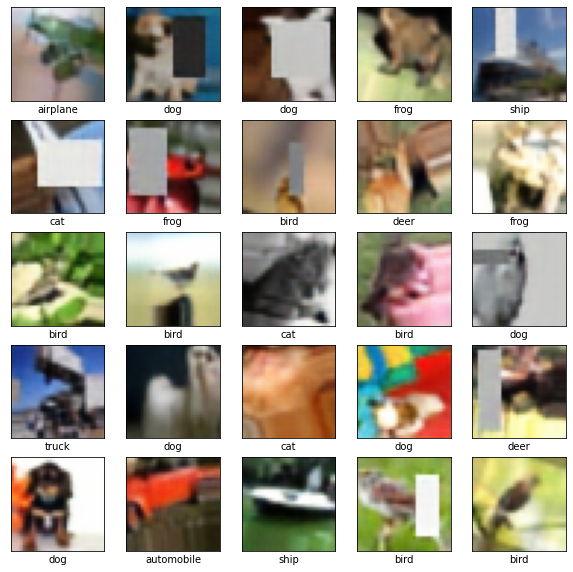

In [ ]:
class BalancedDataGenerator_cls(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, feature_extractor, batch_size=32):
        self.datagen = datagen
        self.feature_extractor = feature_extractor
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        x_batch, y_batch = self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
        x_batch = self.feature_extractor.predict(x_batch)
        return x_batch, y_batch
        
batch_size = 16
cls_train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.7,1.3],
        shear_range=0.2,
        zoom_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True,
        preprocessing_function=get_random_eraser(v_l=0, v_h=255))  

cls_val_datagen = ImageDataGenerator(rescale=1./255)
cls_train_generator = BalancedDataGenerator_cls(train_images, train_labels[:,0], cls_train_datagen, ae_model , batch_size=batch_size)

imgs = []
labels = []
for i in range(train_steps_per_epoch):
    img_batch, label_batch = cls_train_generator.__getitem__(0)
    imgs.extend(img_batch)
    labels.extend(label_batch)     

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imgs[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i]])
plt.show()

In case, you wanna try model type 2. which has much less parameters on the decoder side.

In [ ]:
# # train ae model type 2
# kernel_regularizer = None #0.0000001
# ae_model2 = CovAutoencoder2(kernel_regularizer)
# def step_decay(epoch):
#    initial_lrate = 1e-3
#    drop = 0.5
#    epochs_drop = 10
#    lrate = initial_lrate * math.pow(drop,  
#            math.floor((1+epoch)/epochs_drop))
#    return lrate
# lrate = LearningRateScheduler(step_decay)
# epochs = 30
# # optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
# optimizer = Adam()
# ae_model2.compile(optimizer=optimizer, loss = loss_function)
# # early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='min')
# ae_model2.build(input_shape= (None, 32, 32, 3))
# print(ae_model2.summary())

# history = ae_model2.fit_generator(ae_train_generator, 
#                     steps_per_epoch=train_steps_per_epoch, 
#                     epochs=epochs, 
#                     validation_data=ae_val_generator, 
#                     validation_steps=val_steps_per_epoch)

Btw, I have found another typee of model where you feed the featuures from the previous layers to the decoder create the images

I have got the original code from this https://www.kaggle.com/mahtabshaan/autoencoder-as-feature-extractor-cifar10

lets try it also!

In [ ]:
def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x
    
# this is kind of sparse encoder
def get_new_ae_model(): 
    input = Input((32,32,3))
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    middle = create_block(x, 128)   # we could add sigmoid instead of relu here
    x = Conv2DTranspose(64, kernel_size=2, strides=2)(middle)
    x = Concatenate()([block2, x])
    x = create_block(x, 64)
    x = Conv2DTranspose(32, kernel_size=2, strides=2)(x)
    x = Concatenate()([block1, x])
    #output
    x = Conv2D(3, 1)(x)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)
feature_part ,new_ae = get_new_ae_model()

In [ ]:
def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.5
   epochs_drop = 10
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)
epochs = 30

# optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
optimizer = Adam()
new_ae.compile(optimizer=optimizer, loss = loss_function)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='min')
new_ae.build(input_shape= (None, 32, 32, 3))
# print(new_ae.summary())
history = new_ae.fit_generator(ae_train_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=ae_val_generator, 
                    validation_steps=val_steps_per_epoch,
                    callbacks = [lrate])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/30
312/312 [==============================] - 32s 103ms/step - loss: 0.0023 - val_loss: 0.0117
Epoch 2/30
312/312 [==============================] - 32s 102ms/step - loss: 6.4699e-04 - val_loss: 4.8308e-04
Epoch 3/30
312/312 [==============================] - 32s 103ms/step - loss: 5.2478e-04 - val_loss: 2.3529e-04
Epoch 4/30
312/312 [==============================] - 32s 103ms/step - loss: 4.8180e-04 - val_loss: 1.8158e-04
Epoch 5/30
312/312 [==============================] - 32s 103ms/step - loss: 4.1894e-04 - val_loss: 1.6631e-04
Epoch 6/30
312/312 [==============================] - 33s 104ms/step - loss: 4.1325e-04 - val_loss: 2.2626e-04
Epoch 7/30
312/312 [==============================] - 32s 103ms/step - loss: 3.5889e-04 - val_loss: 1.5573e-04
Epoch 8/30
312/312 [==============================] - 32s 101ms/step - loss: 3.6541e-04 - val_loss: 1.3355e-04
Epoch 9/30
312/312 [==============================] - 32s 102ms/step - loss: 3.2897e-04 - val_loss: 1.2262e-04
Epoch 10/

In [ ]:
new_ae.save('/content/drive//My Drive/Colab Notebooks/saved_models/new_ae')
feature_part.save('/content/drive//My Drive/Colab Notebooks/saved_models/feature_part')

INFO:tensorflow:Assets written to: /content/drive//My Drive/Colab Notebooks/saved_models/new_ae/assets
INFO:tensorflow:Assets written to: /content/drive//My Drive/Colab Notebooks/saved_models/feature_part/assets


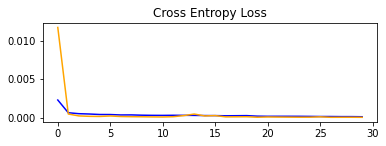

In [ ]:
def summarize_diagnostics(history):
	  # plot loss
	  plt.subplot(211)
	  plt.title('Cross Entropy Loss')
	  plt.plot(history.history['loss'], color='blue', label='train')
	  plt.plot(history.history['val_loss'], color='orange', label='test')
	  # plot accuracy
	  # plt.subplot(212)
	  # plt.title('Classification Accuracy')
	  # plt.plot(history.history['accuracy'], color='blue', label='train')
	  # plt.plot(history.history['val_accuracy'], color='orange', label='test')
	  plt.show()
summarize_diagnostics(history)


In [ ]:
new_ae = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/new_ae',compile=False)
feature_part = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/feature_part',compile=False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


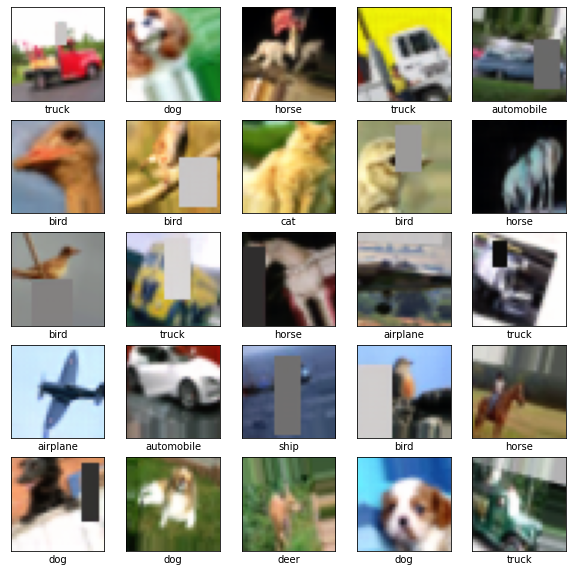

In [ ]:
batch_size = 1024
cls_train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.7,1.3],
        shear_range=0.2,
        zoom_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True,
        preprocessing_function=get_random_eraser(v_l=0, v_h=255))  

cls_val_datagen = ImageDataGenerator(rescale=1./255)
cls_train_generator = BalancedDataGenerator_cls(train_images, train_labels[:,0], cls_train_datagen, new_ae , batch_size=batch_size)

imgs = []
labels = []
for i in range(train_steps_per_epoch):
    img_batch, label_batch = cls_train_generator.__getitem__(0)
    imgs.extend(img_batch)
    labels.extend(label_batch)     

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imgs[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i]])
plt.show()

In [ ]:
ae_model = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/ae_model1', compile=False)
feature_extractor = ae_model.get_layer('cov_ec')
new_ae = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/new_ae',compile=False)
feature_part = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/feature_part',compile=False)

#Next lets defnine our clasifier

In [ ]:
cls_model = Sequential([
            InputLayer(input_shape=(8,8,128)),
            Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(),   
            Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(),   
            MaxPool2D(),
            Conv2D(filters= 64, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(), 
            Conv2D(filters= 32, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(), 
            Flatten(),
            Dense(512),
            BatchNormalization(),
            ReLU(), 
            Dense(256),
            BatchNormalization(),
            ReLU(), 
            Dense(100),
            BatchNormalization(),
            ReLU(), 
            Dense(10, activation='softmax') 
])
print(cls_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 256)         294912    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 128)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 128)         0

#lets create balanced generator for training clasifier

In [ ]:
# Data gen for clssification model
class BalancedDataGenerator_cls(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, feature_extractor, batch_size=32):
        self.datagen = datagen
        self.feature_extractor = feature_extractor
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        x_batch, y_batch = self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
        x_batch = self.feature_extractor.predict(x_batch)
        return x_batch, y_batch

def summarize_diagnostics(history):
	  # plot loss
	  plt.subplot(211)
	  plt.title('Cross Entropy Loss')
	  plt.plot(history.history['loss'], color='blue', label='train')
	  plt.plot(history.history['val_loss'], color='orange', label='test')
	  #plot accuracy
	  plt.subplot(212)
	  plt.title('Classification Accuracy')
	  plt.plot(history.history['accuracy'], color='blue', label='train')
	  plt.plot(history.history['val_accuracy'], color='orange', label='test')
	  plt.show()

# train clasification with no augmentation + use feature_extractor from ae_model1 (cls_model1)

In [ ]:
batch_size = 16
cls_train_datagen = ImageDataGenerator(rescale=1./255)
cls_val_datagen = ImageDataGenerator(rescale=1./255)
cls_train_generator = BalancedDataGenerator_cls(train_images, train_labels[:,0], cls_train_datagen, feature_extractor, batch_size=batch_size)
train_steps_per_epoch = cls_train_generator.steps_per_epoch
cls_val_generator = BalancedDataGenerator_cls(val_images, val_labels[:,0], cls_val_datagen, feature_extractor, batch_size=256)
val_steps_per_epoch = cls_val_generator.steps_per_epoch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


train

In [ ]:
# plss always run the cell that define classfication first before training any new clasifier
def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.5
   epochs_drop = 30
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)
epochs = 100

# optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
optimizer = Adam()
cls_model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
cls_history = cls_model.fit_generator(cls_train_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=cls_val_generator, 
                    validation_steps=val_steps_per_epoch,
                    callbacks = [lrate])

Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/100
2500/2500 [==============================] - 88s 35ms/step - loss: 1.3490 - accuracy: 0.5185 - val_loss: 1.0759 - val_accuracy: 0.6081
Epoch 2/100
2500/2500 [==============================] - 87s 35ms/step - loss: 0.9950 - accuracy: 0.6511 - val_loss: 1.0569 - val_accuracy: 0.6306
Epoch 3/100
2500/2500 [==============================] - 87s 35ms/step - loss: 0.7685 - accuracy: 0.7333 - val_loss: 1.0915 - val_accuracy: 0.6442
Epoch 4/100
2500/2500 [==============================] - 88s 35ms/step - loss: 0.5738 - accuracy: 0.8001 - val_loss: 1.0981 - val_accuracy: 0.6610
Epoch 5/100
2500/2500 [==============================] - 87s 35ms/step - loss: 0.4134 - accuracy: 0.8557 - val_loss: 1.2279 - val_accuracy: 0.6701
Epoch 6/100
2500/2500 [==============================] - 87s 35ms/step - loss: 0.3148 - accuracy: 0.8899 - val_loss: 1.2418 - val_accuracy: 0.6809
Epoch 7/100
2500/2500 [==============================] - 87s 35ms/step - loss: 0.2392 - accuracy: 0.9164 - val_loss: 1

It could be seen that this model suffer from overfitting problem. We could improve more by regularization. (but in fact val accuracy is still increasing. Maybe it can increase a bit more)

In [ ]:
# save cls_model1
cls_model.save('/content/drive//My Drive/Colab Notebooks/saved_models/cls_model1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive//My Drive/Colab Notebooks/saved_models/cls_model1/assets


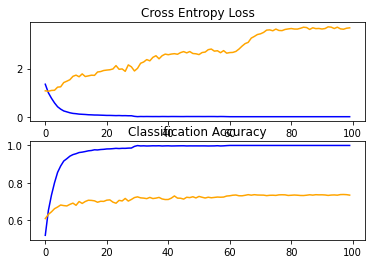

In [ ]:
summarize_diagnostics(cls_history)

look overfiting (but in fact if we train longer, I think the validation loss could increas further )

# train clasification with Images Augmentation + use feature_extractor from ae_model1 (cls_model2)

In [ ]:
cls_model = Sequential([
            InputLayer(input_shape=(8,8,128)),
            Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(),   
            Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(),   
            MaxPool2D(),
            Conv2D(filters= 64, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(), 
            Conv2D(filters= 32, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(), 
            Flatten(),
            Dense(512),
            BatchNormalization(),
            ReLU(), 
            Dense(256),
            BatchNormalization(),
            ReLU(), 
            Dense(100),
            BatchNormalization(),
            ReLU(), 
            Dense(10, activation='softmax') 
])

batch_size = 16
cls_train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.7,1.3],
        shear_range=0.2,
        zoom_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True,
        preprocessing_function= get_random_eraser(v_l=0, v_h=255))
cls_val_datagen = ImageDataGenerator(rescale=1./255)

cls_train_generator = BalancedDataGenerator_cls(train_images, train_labels[:,0], cls_train_datagen, feature_extractor , batch_size=batch_size)
train_steps_per_epoch = cls_train_generator.steps_per_epoch
cls_val_generator = BalancedDataGenerator_cls(val_images, val_labels[:,0], cls_val_datagen, feature_extractor, batch_size=256)
val_steps_per_epoch = cls_val_generator.steps_per_epoch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train

In [ ]:
def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.5
   epochs_drop = 30
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)
epochs = 100

# optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
optimizer = Adam()
cls_model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
cls_history = cls_model.fit_generator(cls_train_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=cls_val_generator, 
                    validation_steps=val_steps_per_epoch,
                    callbacks = [lrate])

Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/100
2500/2500 [==============================] - 112s 45ms/step - loss: 1.7014 - accuracy: 0.3857 - val_loss: 1.5414 - val_accuracy: 0.4800
Epoch 2/100
2500/2500 [==============================] - 113s 45ms/step - loss: 1.4806 - accuracy: 0.4695 - val_loss: 1.2153 - val_accuracy: 0.5619
Epoch 3/100
2500/2500 [==============================] - 111s 45ms/step - loss: 1.3833 - accuracy: 0.5066 - val_loss: 1.1633 - val_accuracy: 0.5906
Epoch 4/100
2500/2500 [==============================] - 111s 45ms/step - loss: 1.3046 - accuracy: 0.5380 - val_loss: 1.2494 - val_accuracy: 0.5854
Epoch 5/100
2500/2500 [==============================] - 112s 45ms/step - loss: 1.2462 - accuracy: 0.5619 - val_loss: 1.0134 - val_accuracy: 0.6450
Epoch 6/100
2500/2500 [==============================] - 111s 44ms/step - loss: 1.2011 - accuracy: 0.5755 - val_loss: 0.9672 - val_accuracy: 0.6627
Epoch 7/100
2500/2500 [==============================] - 112s 45ms/step - loss: 1.1550 - accuracy: 0.5921 - val_

In [ ]:
# save cls_model2
cls_model.save('/content/drive//My Drive/Colab Notebooks/saved_models/cls_model2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive//My Drive/Colab Notebooks/saved_models/cls_model2/assets


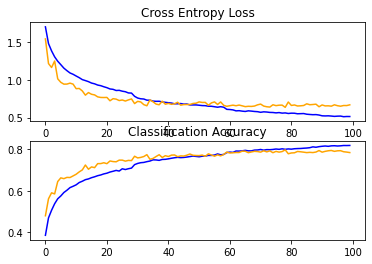

In [ ]:
summarize_diagnostics(cls_history)

This model shows promising result and i think if we train for more epoach, the val_accuracy could be improved more. 

# train clasification with no augmentation + use feature_part from new_ae model (cls_model3)

In [ ]:
cls_model = Sequential([
            InputLayer(input_shape=(8,8,128)),
            Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(),   
            Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(),   
            MaxPool2D(),
            Conv2D(filters= 64, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(), 
            Conv2D(filters= 32, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(), 
            Flatten(),
            Dense(512),
            BatchNormalization(),
            ReLU(), 
            Dense(256),
            BatchNormalization(),
            ReLU(), 
            Dense(100),
            BatchNormalization(),
            ReLU(), 
            Dense(10, activation='softmax') 
])

batch_size = 16
cls_train_datagen = ImageDataGenerator(rescale=1./255)
cls_val_datagen = ImageDataGenerator(rescale=1./255)
cls_train_generator = BalancedDataGenerator_cls(train_images, train_labels[:,0], cls_train_datagen, feature_part, batch_size=batch_size)
train_steps_per_epoch = cls_train_generator.steps_per_epoch
cls_val_generator = BalancedDataGenerator_cls(val_images, val_labels[:,0], cls_val_datagen, feature_part, batch_size=256)
val_steps_per_epoch = cls_val_generator.steps_per_epoch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train

In [ ]:
def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.5
   epochs_drop = 30
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)
epochs = 100

# optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
optimizer = Adam()
cls_model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
cls_history = cls_model.fit_generator(cls_train_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=cls_val_generator, 
                    validation_steps=val_steps_per_epoch,
                    callbacks = [lrate])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/100
2500/2500 [==============================] - 88s 35ms/step - loss: 1.7510 - accuracy: 0.3681 - val_loss: 1.5434 - val_accuracy: 0.4351
Epoch 2/100
2500/2500 [==============================] - 87s 35ms/step - loss: 1.5178 - accuracy: 0.4562 - val_loss: 1.4505 - val_accuracy: 0.4864
Epoch 3/100
2500/2500 [==============================] - 86s 34ms/step - loss: 1.3753 - accuracy: 0.5099 - val_loss: 1.4249 - val_accuracy: 0.4998
Epoch 4/100
2500/2500 [==============================] - 86s 35ms/step - loss: 1.2283 - accuracy: 0.5674 - val_loss: 1.4211 - val_accuracy: 0.5074
Epoch 5/100
2500/2500 [==============================] - 86s 34ms/step - loss: 1.0716 - accuracy: 0.6272 - val_loss: 1.4629 - val_accuracy: 0.5027
Epoch 6/100
2500/2500 [==============================] - 86s 35ms/step - loss: 0.9074 - accuracy: 0.6859 - val_loss: 1.6191 - val_accuracy: 0.4977
Epoch 7/100
2500/2500 [==============================] - 87s 35ms/step - loss: 0.7512 - accuracy: 0.7402 - val_loss: 1

In [ ]:
# save cls_model3
cls_model.save('/content/drive//My Drive/Colab Notebooks/saved_models/cls_model3')

INFO:tensorflow:Assets written to: /content/drive//My Drive/Colab Notebooks/saved_models/cls_model3/assets


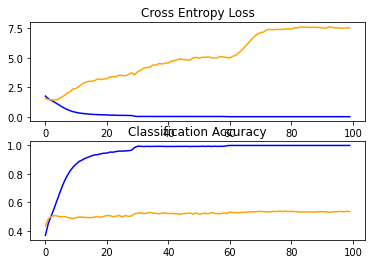

In [ ]:
summarize_diagnostics(cls_history)

This one really suffers from overfiting.

# train clasification with Image Augmentation + use feature_part from new_ae model (cls_model4)

In [ ]:
cls_model = Sequential([
            InputLayer(input_shape=(8,8,128)),
            Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(),   
            Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(),   
            MaxPool2D(),
            Conv2D(filters= 64, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(), 
            Conv2D(filters= 32, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(), 
            Flatten(),
            Dense(512),
            BatchNormalization(),
            ReLU(), 
            Dense(256),
            BatchNormalization(),
            ReLU(), 
            Dense(100),
            BatchNormalization(),
            ReLU(), 
            Dense(10, activation='softmax') 
])

batch_size = 16
cls_train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.7,1.3],
        shear_range=0.2,
        zoom_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True,
        preprocessing_function= get_random_eraser(v_l=0, v_h=255))
cls_val_datagen = ImageDataGenerator(rescale=1./255)

cls_train_generator = BalancedDataGenerator_cls(train_images, train_labels[:,0], cls_train_datagen, feature_part , batch_size=batch_size)
train_steps_per_epoch = cls_train_generator.steps_per_epoch
cls_val_generator = BalancedDataGenerator_cls(val_images, val_labels[:,0], cls_val_datagen, feature_part, batch_size=256)
val_steps_per_epoch = cls_val_generator.steps_per_epoch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


train

In [ ]:
def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.5
   epochs_drop = 30
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)
epochs = 100

# optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
optimizer = Adam()
cls_model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
cls_history = cls_model.fit_generator(cls_train_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=cls_val_generator, 
                    validation_steps=val_steps_per_epoch,
                    callbacks = [lrate])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/100
2500/2500 [==============================] - 112s 45ms/step - loss: 1.9918 - accuracy: 0.2724 - val_loss: 1.6964 - val_accuracy: 0.3961
Epoch 2/100
2500/2500 [==============================] - 112s 45ms/step - loss: 1.8570 - accuracy: 0.3212 - val_loss: 1.5988 - val_accuracy: 0.4243
Epoch 3/100
2500/2500 [==============================] - 111s 44ms/step - loss: 1.7974 - accuracy: 0.3476 - val_loss: 1.5461 - val_accuracy: 0.4351
Epoch 4/100
2500/2500 [==============================] - 112s 45ms/step - loss: 1.7516 - accuracy: 0.3665 - val_loss: 1.5074 - val_accuracy: 0.4545
Epoch 5/100
2500/2500 [==============================] - 112s 45ms/step - loss: 1.7172 - accuracy: 0.3784 - val_loss: 1.4763 - val_accuracy: 0.4720
Epoch 6/100
2500/2500 [==============================] - 112s 45ms/step - loss: 1.6882 - accuracy: 0.3925 - val_loss: 1.4604 - val_accuracy: 0.4766
Epoch 7/100
2500/2500 [==============================] - 112s 45ms/step - loss: 1.6580 - accuracy: 0.4061 - val_

In [ ]:
# save cls_model4
cls_model.save('/content/drive//My Drive/Colab Notebooks/saved_models/cls_model4')

INFO:tensorflow:Assets written to: /content/drive//My Drive/Colab Notebooks/saved_models/cls_model4/assets


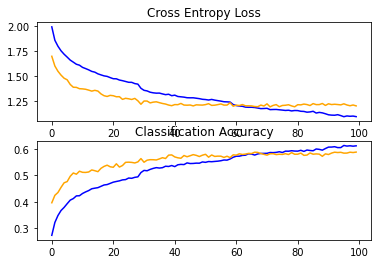

In [ ]:
summarize_diagnostics(cls_history)

In [ ]:
(train_val_images, train_val_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
class FullModel(Model): 
    def __init__(self,feature_extractor, cls_model):
        super(FullModel, self).__init__()

        # Feature extractor
        self.feature_extractor = feature_extractor
        # clasification
        self.cls_model = cls_model

    def call(self, inputs):
        z = self.feature_extractor(inputs, training=False)
        y_hat = self.cls_model(z, training=False)
        return y_hat

In [ ]:
ae_model = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/ae_model1', compile=False)
feature_extractor = ae_model.get_layer('cov_ec')
new_ae = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/new_ae',compile=False)
feature_part = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/feature_part',compile=False)
cls_model1 = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/cls_model1',compile=False)
cls_model2 = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/cls_model2',compile=False)
cls_model3 = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/cls_model3',compile=False)
cls_model4 = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/cls_model4',compile=False)

optimizer = Adam()

# make 4 full model from 4 cls_models
full_model1 = FullModel(feature_extractor, cls_model1)
full_model1.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy']) 
full_model2 = FullModel(feature_extractor, cls_model2)
full_model2.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy']) 
full_model3 = FullModel(feature_part, cls_model3)
full_model3.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy']) 
full_model4 = FullModel(feature_part, cls_model4)
full_model4.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy']) 

all_model = [full_model1,full_model2,full_model3,full_model4]  

#Performance on test set

In [ ]:
# performace on test set
test_images_normoalize = test_images/255

for j ,full_model in enumerate(all_model):
    loss, acc = full_model.evaluate(test_images_normoalize,  test_labels, verbose=2)
    print('performance of full_model number {}'.format(j+1))
    print('Full model, accuracy: {:5.2f}% , loss : {}'.format(100*acc, loss))

313/313 - 29s - loss: 3.9364 - accuracy: 0.7302
performance of full_model number 1
Full model, accuracy: 73.02% , loss : 3.9363996982574463
313/313 - 29s - loss: 0.6560 - accuracy: 0.7968
performance of full_model number 2
Full model, accuracy: 79.68% , loss : 0.6559925079345703
313/313 - 30s - loss: 7.6683 - accuracy: 0.5310
performance of full_model number 3
Full model, accuracy: 53.10% , loss : 7.66829776763916
313/313 - 30s - loss: 1.2107 - accuracy: 0.5845
performance of full_model number 4
Full model, accuracy: 58.45% , loss : 1.2107058763504028


#Summary

In this home work, I trained autoencoder and clasification separately.

#Data preparation
I firstly explaore the data and from the condition of the home work that class bird, deer , and truck should be only 50% of the originale data.

Here we have to tackle the problem of unbalanced data. I firstly think about using Smote (which i expericed using it for structred data and it worked well) for oversampling + undersapling to solve this problem. But the Smote does not genereate good images for us as I observed. The deteailed information is explained above with the code. 

So,I decided to use re-sampling with replacement method for this problem. This allows our network to have change to learn all classes equally. Even thought this mathod does not add information to the network.  I add data augmentation which is expected to add some slight information to the network. Therefore, even thought the minor classes(bird, derr, truck) are pick twice in an eproch for network to learn, those 2 images are not exacly the same.

Recommend on future work on this part:
1. you could try Smote method(since i did not experiment yet) + undersampling
2. You could try class weight method (But i guess the result should be similar with re-sampling with replacement)
3. Actually, I miss something in this homework. when I prepare the data, split the train first and then remove the major classes data in the validation set, val data sets first by 20% >> minor classes = 500 major classes = 1000. So, I just loss 500 images of data from the major classes.
So this time :
train major = 4000
train minor = 2000
val major = 500
vaal minor = 500
But if i separate data for val major and val minor first by 500 data
then 
train major = 4500 
train minor = 2000
val major = 500
vaal minor = 500

so here we can trin to train on this data set  instead also. 

#Data augmentation method
Next I was thinking about data augmentation for solveing overfitiing problem because i reserch that may model overfit the cifar-10.

I have read the paper before about random cut off and I think I would like to try to use it for this problem additional to standard data augmentation.

Recommend on future work on this part:

1. We could compare data augmentation with/without random cut-off method and see the effect of the random cut-off method.


#Autoencoder
Then, I start traing the autoencoder, I defined 4 types of autoencoder.
1 stack type : unfortunately, the loss is not reduce as I expected. (I explain my idea above with code)
2. cov type : we use this one and I name as 'ae_model1'
3. cov type but has considereby more weight at the encoder side (I assume that this model could extrac better feature because it will reply a lot on the encoder side ). I name it as 'ae_model2'
4. Feature passing autoencoder : I found this on the internet so I want to compared with our model. The acchitecture is the same as ae_model1 except that it passes the features from the ealier layers to the decoder layers   I name it as 'new_ae'

so for encoder I use  ae_model1 vs new_ae (if i have more time I would like to experiment with other type also, especially ae_model1 vs ae_model2)

It looks like new_ae perform better than ae_model1 on the image construction task.
But is it perform better on extracting the features?

I will check when training with clasification.

Recommend on future work on this part:
1. try out the other 2 autoencoder model as I mentioned above.
2. try the resnet autoencoder with many blocks. I have tried to decide the code block for this part but I did not finished yet.


# Clasification
Here I defined only one normal CNN with the block similar to VVG block style. 
This is just because I want to start simple first and VGG is actually ourperformed many types of network (not count very deep layers network).

I have test 2 types of conbined model
1. cls_model1 = feature_extractor(features extractor from ae_model1) + normal CNN
2. cls_model3 = feature_part(features extractor from new_ae) + normal CNN

It looks like in both cases they have experienced overfiting problem 
So I add image augmentation to the generator. 

3. cls_model2 = cls_model1 but train on augmented data
4. cls_model4 = cls_model3 but train on augmented data

Here is another finding. With the same CNN, the feature_extractor proformed better than feature_part as the feasture extractor on 30 eproach even if the feature_part did better on image reconstruction. 
This could be because the whole new_ae model does not fucus on the buttle neck part only but it got help from the featues from the ealier to reconstruct the image. n contrast the ae_model1 has to rely on the buttle neck features only to genereate the images. Therefore, it emphasize the bottle neck layers to get good features during the training.  

From this finding, I could assume one more hypothesis that If we make AE model which has more layers on encoder side than decoder side, This could be a better architechture in which we have balanced layers on both sides. This way the Autoencoder could emphasize more one the encoder side. Since we will get the features from the encoder side, we could get the benefit from it. 


Recommend on future work on this part:
This time I designed only VVG-style network. 

1. I could try to train more bigger network with longer time together with my augmentation method. Also, since the network will be big, we could use resnet-like network for both Autoencoder(encoder part) and clasification model because resnet is designed to solved the problem of wieght vanishing in the big net work. This could give an interesting result. 
2. you can try to add the weight decay (L1 or L2 to the network also) or even dropput() layers if you will have to generalize the network.



So, I think this is end of my home work. Note. I will be better if you visualize the confusion metrix also to see how weel the model deal with class bird. deer, and truck. 

# Train only CNN without Autoencoder + image augmentation

In [ ]:
# Data gen for normal cov
class BalancedDataGenerator_covnet(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        x_batch, y_batch = self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
        return x_batch, y_batch

def summarize_diagnostics(history):
	  # plot loss
	  plt.subplot(211)
	  plt.title('Cross Entropy Loss')
	  plt.plot(history.history['loss'], color='blue', label='train')
	  plt.plot(history.history['val_loss'], color='orange', label='test')
	  #plot accuracy
	  plt.subplot(212)
	  plt.title('Classification Accuracy')
	  plt.plot(history.history['accuracy'], color='blue', label='train')
	  plt.plot(history.history['val_accuracy'], color='orange', label='test')
	  plt.show()

Create architechture same with encoder block

In [ ]:

class BasicCovEncoderEntryBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, padding='same', kernel_regularizer=None):
        if kernel_regularizer is not None:
            kernel_regularizer = L1L2(l1=kernel_regularizer)
        super(BasicCovEncoderEntryBlock, self).__init__()
        self.block = Sequential([
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),  #LeakyReLU
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),   
            MaxPool2D()
        ])

    def call(self, inputs, training=False):
        return self.block(inputs, training=training)

class BasicCovEncoderLastBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, padding='same', kernel_regularizer=None):
        if kernel_regularizer is not None:
            kernel_regularizer = L1L2(l1=kernel_regularizer)
        super(BasicCovEncoderLastBlock, self).__init__()
        self.block = Sequential([
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),   #ReLU() #LeakyReLU
            Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_regularizer=kernel_regularizer),
            BatchNormalization(),
            ReLU(),
        ])

    def call(self, inputs, training=False):
        return self.block(inputs, training=training)

In [ ]:
covnet = Sequential([
            InputLayer(input_shape=(32,32,3)),
            BasicCovEncoderEntryBlock(32, kernel_regularizer=None),
            BasicCovEncoderEntryBlock(64, kernel_regularizer=None),
            BasicCovEncoderLastBlock(128, kernel_regularizer=None),
            Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(),   
            Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(),   
            MaxPool2D(),
            Conv2D(filters= 64, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(), 
            Conv2D(filters= 32, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            ReLU(), 
            Flatten(),
            Dense(512),
            BatchNormalization(),
            ReLU(), 
            Dense(256),
            BatchNormalization(),
            ReLU(), 
            Dense(100),
            BatchNormalization(),
            ReLU(), 
            Dense(10, activation='softmax') 
])
batch_size = 16
covnet_train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.7,1.3],
        shear_range=0.2,
        zoom_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True,
        preprocessing_function= get_random_eraser(v_l=0, v_h=255))
covnet_val_datagen = ImageDataGenerator(rescale=1./255)

covnet_train_generator = BalancedDataGenerator_covnet(train_images, train_labels[:,0], covnet_train_datagen, batch_size=batch_size)
train_steps_per_epoch = covnet_train_generator.steps_per_epoch
covnet_val_generator = BalancedDataGenerator_covnet(val_images, val_labels[:,0], covnet_val_datagen, batch_size=256)
val_steps_per_epoch = covnet_val_generator.steps_per_epoch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.5
   epochs_drop = 30
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)
epochs = 100

optimizer = Adam()
covnet.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
covnet_history = covnet.fit_generator(covnet_train_generator, 
                    steps_per_epoch=train_steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=covnet_val_generator, 
                    validation_steps=val_steps_per_epoch,
                    callbacks = [lrate])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/100
2500/2500 [==============================] - 44s 18ms/step - loss: 1.8184 - accuracy: 0.3338 - val_loss: 1.8027 - val_accuracy: 0.3735
Epoch 2/100
2500/2500 [==============================] - 42s 17ms/step - loss: 1.5475 - accuracy: 0.4381 - val_loss: 1.3284 - val_accuracy: 0.5243
Epoch 3/100
2500/2500 [==============================] - 43s 17ms/step - loss: 1.3725 - accuracy: 0.5148 - val_loss: 1.2338 - val_accuracy: 0.5687
Epoch 4/100
2500/2500 [==============================] - 43s 17ms/step - loss: 1.2440 - accuracy: 0.5632 - val_loss: 1.3973 - val_accuracy: 0.5626
Epoch 5/100
2500/2500 [==============================] - 44s 17ms/step - loss: 1.1513 - accuracy: 0.5977 - val_loss: 1.1126 - val_accuracy: 0.6246
Epoch 6/100
2500/2500 [==============================] - 43s 17ms/step - loss: 1.0712 - accuracy: 0.6289 - val_loss: 1.4954 - val_accuracy: 0.5527
Epoch 7/100
2500/2500 [==============================] - 43s 17ms/step - loss: 1.0149 - accuracy: 0.6486 - val_loss: 1

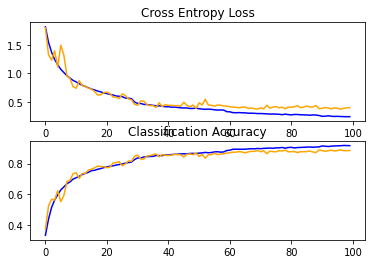

In [ ]:
summarize_diagnostics(covnet_history)

In [ ]:
covnet.save('/content/drive//My Drive/Colab Notebooks/saved_models/covnet')

INFO:tensorflow:Assets written to: /content/drive//My Drive/Colab Notebooks/saved_models/covnet/assets


In [ ]:
covnet = tf.keras.models.load_model('/content/drive//My Drive/Colab Notebooks/saved_models/covnet', compile=False)
covnet.compile(optimizer=Adam(), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Performance on test set
test_images_normoalize = test_images/255
loss, acc = covnet.evaluate(test_images_normoalize,  test_labels, verbose=2)
print('performance of covnet')
print('Accuracy: {:5.2f}% , loss : {:5.4f}'.format(100*acc, loss))

313/313 - 1s - loss: 0.3872 - accuracy: 0.8797
performance of covnet
Accuracy: 87.97% , loss : 0.3872


#Autoencoder + CNN vs CNN  discussion

It looks like that only CNN alone outperform the CNN with Autoencoder.

Here is my opinion with some knowledge that I have learned. (It maybe not true)

In fact, the hidden layers of the CNN itself are already considered as the feature extractor and already do some feature engineering automatically for us during the traning.  

Lets say we have 10 layers for both type of networks (please note that this network will have the same runtime since it has the same number of layers and parameters). And Lets say (for AUtoencoder + CNN) we use the first 4 layers of this network as encoder. Then, to train it, we will define the decoder side and train it by unserpervised learning. Here those 4 layers of this network (so now the layer 4 is the bottle neck) are trianed and aimed for images reconstruction task. Then we will get the weights of the first 4 layers then that as feasture extractor to train the CNN(6 layers). 

#Now,
For Autoencoder + CNN, you will have the first 4 layers which it parameters aimed for image reconstruction task + 6 layers aim for image clasification task.

In contrast, for normal CNN,  all 10 layers are aimed for image clasification task and they are all trained together with the same objective. 

#Therefore,
The first 4 layers of normal CNN could give better feature to the network because it trains on supervised learning together with other layers. 

#Summary 
If we are going to use DNN, we may not have to consider about autoencoder for feature extractor. And, you can just turn that encoder to be just a part of the CNN and just trainthe whole network together. 

However, if you are going to use other type of clasification model (logistic regression, SVM, random forest), now autoencoder as feature extractor may play very important row to improve the model performance. 
(Think like autoencoder as feature extractor similar like the PCA method) 